In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.special as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
#Define Timescape constants
G_SI = 4.49e-15           # gravitational constant, Mpc^3/ (Gyrs^2 * Msolar)
c_SI = 3.06e2             # speed of light in vacuum, Mpc/Gyrs
H0_SI = 7.05e-2           # Gyrs^-1, which is 68.94 km/(s*Mpc) 
# Convert to proper units, i.e.,
h = 0.6894
GyrstoHT = h/9.778
MpctoHL = h/3000
c = 1                                       # correct speed of light, consistent with Ellis-Bruni formalism
G = G_SI * (MpctoHL**3) / (GyrstoHT**2)     # convert to HL^2/(HT^2 * M_solar)
H0 = 1                                      # convert to HT^-1
# Specific model quantities
zT = 1.14                                               # transition redshift
aT = 1/(1+zT)                                           # transition scale factor
epsilon = -0.58                                         # gradient setter
OmegaM0 = 0.33                                          # current matter density (dressed)
OmegaL0 = (1 - (aT**epsilon)*OmegaM0)                   # current dark energy contribution
rhod0 =  OmegaM0*(3*H0**2)/((8*np.pi*G))                # density at the present time
Lambda = 3*(H0**2)*OmegaL0                              # cosmological constant

In [3]:
# Growing mode and other things background definitions

def OmegaMf(z): # Omega Matter
    term1 = OmegaM0*(1+z)**3
    term2= (OmegaL0+OmegaM0*(1+z)**3)
    return term1/term2

def OmegaLf(z): # Omega Lambda
    return OmegaL0/(OmegaL0+OmegaM0*(1+z)**3)

def HF(z): # Hubble parameter
    return H0*np.sqrt(OmegaL0 + OmegaM0*(1+z)**3)

def aFriedman(z): # scale factor
    return 1/(1+z)

def dzdt(z):
    return -(1+z)*HF(z)

def qplus(z):
    u = (1+z)**-3
    x = OmegaL0*u/(OmegaM0 + OmegaL0*u)
    const = (5/6)*( (OmegaM0/OmegaL0)**(1/3) )
    Bx = sp.beta(5/6, 2/3) * sp.betainc(5/6, 2/3, x)
    f = np.sqrt(1 + OmegaM0/(OmegaL0*u))
    return const*Bx*f

def qplus_prime(z):
    epsilon = 1e-5
    return (qplus(z+epsilon)-qplus(z))/epsilon

def qplus_dot(z):
    return qplus_prime(z)*dzdt(z)


In [4]:
#GMP Functions: Part I

def friedmann(t, a):
    rho_m = 8*np.pi*G*rhod0*(aT**epsilon)*(a**(-(3+epsilon)))
    adot = np.sqrt((a**2 / 3.0) * (rho_m + Lambda))
    return adot

#Scale factor
def a(t):
    t_span = np.array([5.087*GyrstoHT, t])
    #print(t_span)
    t_eval = np.linspace(t_span[0], t_span[1], 200)
    sol = solve_ivp(friedmann, t_span, [aT], t_eval=t_eval)
    a = sol.y[0]
    return a[-1]

#Redshift
def z(t):
    return (1/a(t))-1

def dadt(t):
    epsilon = 1e-7
    s = a(t)
    return (a(t+epsilon)-s)/epsilon

def Theta(t):
    epsilon = 1e-7
    s = a(t)
    dadt = (a(t+epsilon)-s)/epsilon
    return 3*dadt/s

In [5]:
#GMP Functions: Part II

#Dust density
def rhod(t):
    c1 = rhod0
    c2 = a(t)**(-3)
    return c1*c2

#Matter density
def rhom(t):
    f = (aT/a(t))**epsilon
    return rhod(t) * f

#Curvature
def RD(t):
    f = (aT/a(t))**epsilon
    term1 = -12*np.pi*G*((1-epsilon/3)*f - 1)*rhod(t)
    return term1

#Backreaction
def QD(t):
    f = (aT/a(t))**epsilon
    term1 = -4*np.pi*G*((1+epsilon) * f - 1)*rhod(t)
    return term1


In [6]:
#GMP Functions: Part III

#Eff. density
def rhoEff(t):
    term1 = rhom(t)-rhod(t)
    return term1

#Eff. pressure
def pEff(t):
    termA = (epsilon/3)*(aT**epsilon)*rhod0
    termB = a(t)**(3+epsilon)
    term1 = termA/termB
    return term1

#Eff. Eos
def wEff(t):
    term1 = ( (epsilon/3)*(a(t)**(-3-epsilon)))*(aT**epsilon)*OmegaM0 
    term2 = ( (a(t)**(-3-epsilon))*(aT**epsilon) - (a(t)**(-3) ) )*OmegaM0 
    return term1/term2

#Eff. "sound" velocity
def cs2Eff(t):
    rhoEffdot =  (rhoEff(t+1e-3)-rhoEff(t))/1e-3
    pEffdot =  (pEff(t+1e-3)-pEff(t))/1e-3
    return pEffdot/rhoEffdot

In [7]:
# Set up arrays
af = [] 
RDarr = []
QDarr = []
Harr = []
rhodarr = []
wEffarr = []
cs2Effarr = []
OmegaMLCDM = []
OmegaLambdaLCDM = []
OmegaQLCDM = []
OmegaRLCDM = []
aFLRW = [] 

In [8]:
# In LambdaCDM (pre transition)
z_LCDM = np.flip(np.arange(zT, 20, 0.01))

for z in z_LCDM: # fill the arrays
    OmegaRLCDM.append(0)
    OmegaQLCDM.append(0)
    OmegaMLCDM.append(OmegaMf(z))
    OmegaLambdaLCDM.append(OmegaLf(z))
    aFLRW.append(aFriedman(z))

OmegaMLCDM = np.array(OmegaMLCDM)
OmegaLambdaLCDM = np.array(OmegaLambdaLCDM)
OmegaRLCDM = np.array(OmegaRLCDM)
OmegaQLCDM = np.array(OmegaQLCDM)
aFLRW = np.array(aFLRW)

In [9]:
# Extract quantities of interest for energy balance check and eff. fluid studies
tf = np.arange(5.088, 13.21, 0.01)*GyrstoHT # time evaluation 
for t in tf: # fill the arrays
    RDarr.append(RD(t))
    QDarr.append(QD(t))
    Harr.append(Theta(t)/3)
    rhodarr.append(rhod(t))
    wEffarr.append(wEff(t))
    cs2Effarr.append(cs2Eff(t))
    af.append(a(t))
# Numpy format
RDarr = np.array(RDarr)
QDarr = np.array(QDarr)
Harr = np.array(Harr)
rhodarr = np.array(rhodarr)
wEffarr = np.array(wEffarr)
cs2Effarr = np.array(cs2Effarr)
# Convert in normalised quantities
OmegaR = -RDarr/(6*Harr**2)
OmegaQ = -QDarr/(6*Harr**2)
OmegaM = 8*np.pi*G*rhodarr/(3*Harr**2)
OmegaL = 1-OmegaR-OmegaQ-OmegaM

In [10]:
OmegaR = np.concatenate((OmegaRLCDM, OmegaR))
OmegaQ = np.concatenate((OmegaQLCDM, OmegaQ))
OmegaM = np.concatenate((OmegaMLCDM, OmegaM))
OmegaL = np.concatenate((OmegaLambdaLCDM, OmegaL))
aff = np.concatenate((aFLRW, af))

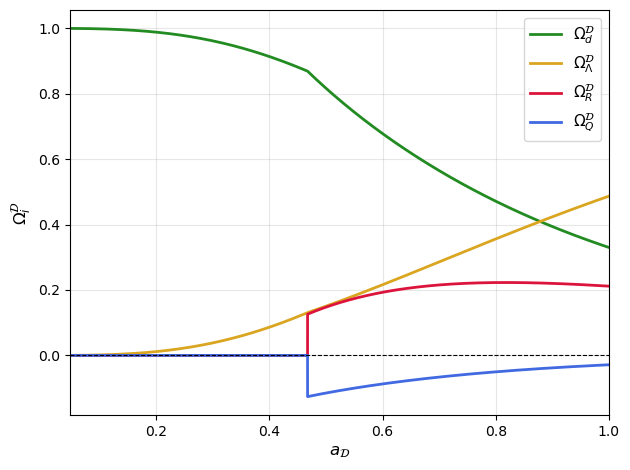

In [11]:
plt.plot(aff, OmegaM, label=r'$\Omega^\mathcal{D}_d$', color='forestgreen', lw=2)
plt.plot(aff, OmegaL, label=r'$\Omega^\mathcal{D}_\Lambda$', color='goldenrod', lw=2)
plt.plot(aff, OmegaR, label=r'$\Omega^\mathcal{D}_R$', color='crimson', lw=2)
plt.plot(aff, OmegaQ, label=r'$\Omega^\mathcal{D}_Q$', color='royalblue', lw=2)
plt.axhline(0, color='k', linestyle='--', lw=0.8)
plt.xlabel(r'$a_\mathcal{D}$', fontsize=12)
plt.ylabel(r'$\Omega^\mathcal{D}_i$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim(np.min(aff), 1)
plt.tight_layout()
plt.savefig('GMP_energy_balance.pdf', format='pdf')
plt.show()

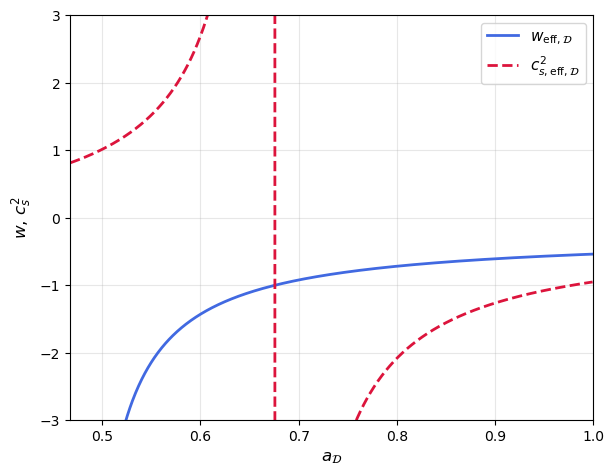

In [12]:
plt.plot(af, wEffarr, label=r'$w_{\mathrm{eff},\mathcal{D}}$', color='royalblue', lw=2)
plt.plot(af, cs2Effarr, '--', label=r'$c_{s,\mathrm{eff},\mathcal{D}}^2$', color='crimson', lw=2)
plt.xlabel(r'$a_\mathcal{D}$', fontsize=12)
plt.ylabel(r'$w$, $c_{s}^2$', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.gca().invert_xaxis()
plt.xlim([np.min(af), 1])
plt.ylim([-3,3])
plt.savefig('GMP_wcs.pdf', format='pdf')
plt.show()

In [13]:
def solnum_barotropic(k,t_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(t):
        return -4*np.pi*G*rhod(t)

    def A22(t):
        return -(2/3)*Theta(t)

    def A23(t):
        term1 = -4*np.pi*G*rhoEff(t)
        term2 = 1+3*cs2Eff(t)
        return term1*term2

    def A32(t):
        return -(1+wEff(t))

    def A33(t):
        return (wEff(t)+cs2Eff(t))*Theta(t)

    def A34(t):
        return ((k**2)/a(t))*(1+wEff(t))

    def A43(t):
        term1 = -cs2Eff(t)/a(t)
        term2 = (1+wEff(t))
        return term1/term2

    def A44(t):
        term1 = Theta(t)/3
        term2 = (3*cs2Eff(t)-1)
        return term1*term2
    # Define a 4x4 time-dependent matrix A(t) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff; 4. Tilt_eff
    def A(t):
        return np.array([
            [  0,        -1,        0,          0   ],
            [A21(t),    A22(t),   A23(t),       0   ],
            [  0,       A32(t),   A33(t),     A34(t)],
            [  0,         0,      A43(t),     A44(t)]
        ])
    
    # Define the ODE system: dv/dt = A(t) @ v
    def system(t, v):
        return A(t) @ v
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    # Solve the system
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval)  

    return sol

In [14]:
def solnum_comoving(t_eval,ic):
    #Define the (non-trivial) single entries in the matrices

    def A21(t):
        return -4*np.pi*G*rhod(t)

    def A22(t):
        return -(2/3)*Theta(t)

    def A23(t):
        return -4*np.pi*G*rhoEff(t)

    def A32(t):
        return -(1+wEff(t))

    def A33(t):
        return wEff(t)*Theta(t)

    # Define a 3x3 time-dependent matrix A(t) which relates the perturbations
    # 1. Delta_dust; 2. Expansion 3.; Delta_eff;
    def A(t):
        return np.array([
            [  0,        -1,        0     ],
            [A21(t),    A22(t),   A23(t)  ],
            [  0,       A32(t),   A33(t)  ]
        ])
    
    # Define the ODE system: dv/dt = A(t) @ v
    def system(t, v):
        return A(t) @ v
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    ic = ic[:-1]  # remove the V_Eff initial condition
    # Solve the system
    sol = solve_ivp(system, t_span, ic, t_eval=t_eval)  

    return sol

In [15]:
# Mezaros Approximation
def solnum_mezaros(t_eval,ic):

    def perturbation_equation(t,y):
        delta, delta_dot = y
        H = Theta(t)/3
        rho_t = rhod(t)
        delta_ddot = 4 * np.pi * G * rho_t * delta - 2 * H * delta_dot
        return [delta_dot, delta_ddot]
    
    t_span = np.array([t_eval[0],t_eval[-1]])
    ic_new = np.array([ic[0],-ic[1]])
    
    sol = solve_ivp(perturbation_equation,t_span,ic_new,t_eval=t_eval)

    return sol

In [16]:
# Time evaluation points
t_eval = np.linspace(5.088*GyrstoHT, 13.21*GyrstoHT, 1000)

CMB_factor = 6.6e-2
# Initial condition (4D vector) fixed to be the initial condition for a typical dust perturbation on a co-moving scale of 150 Mpc/h at present time in the concordance model
ic = [CMB_factor*qplus(zT), -CMB_factor*qplus_dot(zT), -CMB_factor*qplus_dot(zT)/Theta(5.088*GyrstoHT), 0]

In [17]:
#Run the solver
sol_comoving = solnum_comoving(t_eval,ic)
sol_mezaros = solnum_mezaros(t_eval,ic)

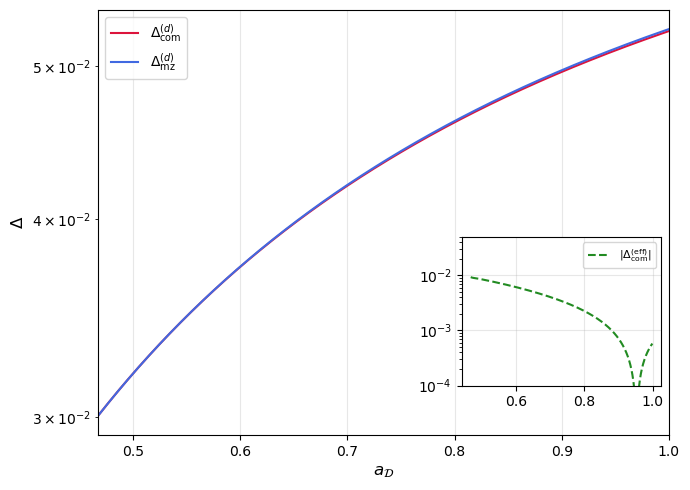

In [18]:
labels_com = [r'$\Delta^{(d)}_{\mathrm{com}}$', r'$|\Delta^{(\mathrm{eff})}_{\mathrm{com}}|$']
labels_mz = [r'$\Delta^{(d)}_{\mathrm{mz}}$']

# Main plot
fig, ax = plt.subplots(figsize=(7,5))
ax.plot([a(t) for t in sol_comoving.t], sol_comoving.y[0], label=labels_com[0], color='crimson')
ax.plot([a(t) for t in sol_mezaros.t], sol_mezaros.y[0], label=labels_mz[0], color='royalblue')

ax.set_xlabel(r'$a_\mathcal{D}$', fontsize=12)
ax.set_ylabel(r'$\Delta$', fontsize=12)
ax.set_xlim([a(t_eval[0]), 1])
ax.set_yscale('log')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()

# Inset axes (zoomed box)
ax_inset = inset_axes(ax, width="35%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.001, 0.1, 1, 1), bbox_transform=ax.transAxes) 
ax_inset.plot([a(t) for t in sol_comoving.t], np.abs(sol_comoving.y[2]), '--', color='forestgreen', label=labels_com[1])
ax_inset.set_ylim([1e-4,5e-2])
ax_inset.set_yscale('log')
ax_inset.grid(alpha=0.3)
ax_inset.legend(fontsize=8)

plt.savefig('All_Perturbations_GMP.pdf', format='pdf')
plt.show()

C:\Users\mrcga\AppData\Local\Temp\ipykernel_17608\1615174613.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  return pEffdot/rhoEffdot
C:\Users\mrcga\AppData\Local\Temp\ipykernel_17608\2761594641.py:45: RuntimeWarning: invalid value encountered in matmul
  return A(t) @ v


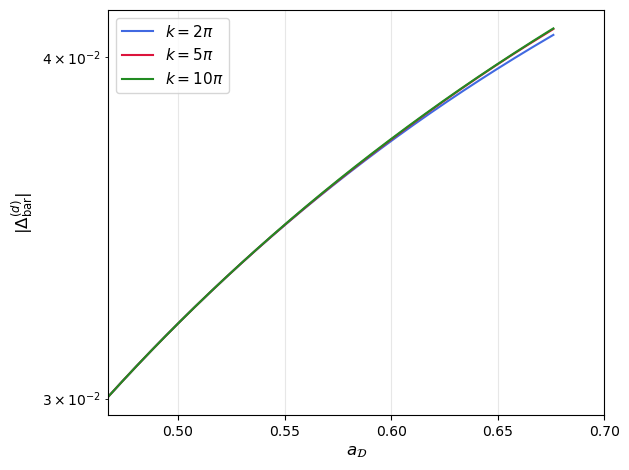

In [19]:
k_vector = [ 2*np.pi, 5*np.pi, 10*np.pi]
labels_k = [r'$k = 2\pi$',r'$k = 5\pi$',r'$k = 10\pi$']
sol_bar = {}
colors = ['royalblue','crimson','forestgreen']


for i in range(len(k_vector)):
    k = k_vector[i]
    sol_bar[k] = solnum_barotropic(k,t_eval,ic)
    plt.plot([a(t) for t in sol_bar[k].t], np.abs(sol_bar[k].y[0]), label=labels_k[i], color = colors[i])
    
plt.yscale('log')
plt.xlabel(r'$a_\mathcal{D}$', fontsize=12)
plt.ylabel(r'$|\Delta^{(d)}_\mathrm{bar}|$', fontsize=12)
plt.xlim([a(t_eval[0]),0.7])
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('Bar_Dusts_GMP.pdf', format='pdf')
plt.show()


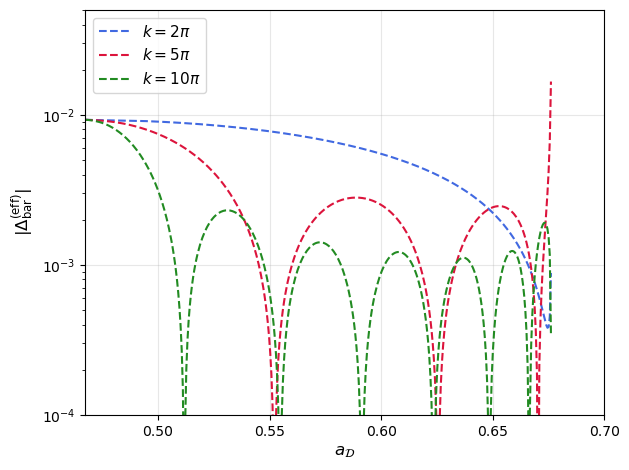

In [20]:
for i in range(len(k_vector)):
    k = k_vector[i]
    plt.plot([a(t) for t in sol_bar[k].t], np.abs(sol_bar[k].y[2]),'--', label=labels_k[i], color = colors[i])
    
plt.ylim([1e-4,5e-2])
plt.yscale('log')
plt.xlabel(r'$a_\mathcal{D}$', fontsize=12)
plt.xlim([a(t_eval[0]),0.7])
plt.ylabel(r'$|\Delta^{\mathrm{(eff)}}_\mathrm{bar}|$', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('Bar_eff_GMP.pdf', format='pdf')
plt.show()